In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import r2_score
%matplotlib inline
 
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')

In [2]:
sales_data = pd.read_csv('retail_sales.csv')
sales_data['date']=pd.to_datetime(sales_data['date'])
sales_data.set_index('date', inplace=True)

In [3]:
sales_data.head()

sales
date              
2009-10-01  338630
2009-11-01  339386
2009-12-01  400264
2010-01-01  314640
2010-02-01  311022

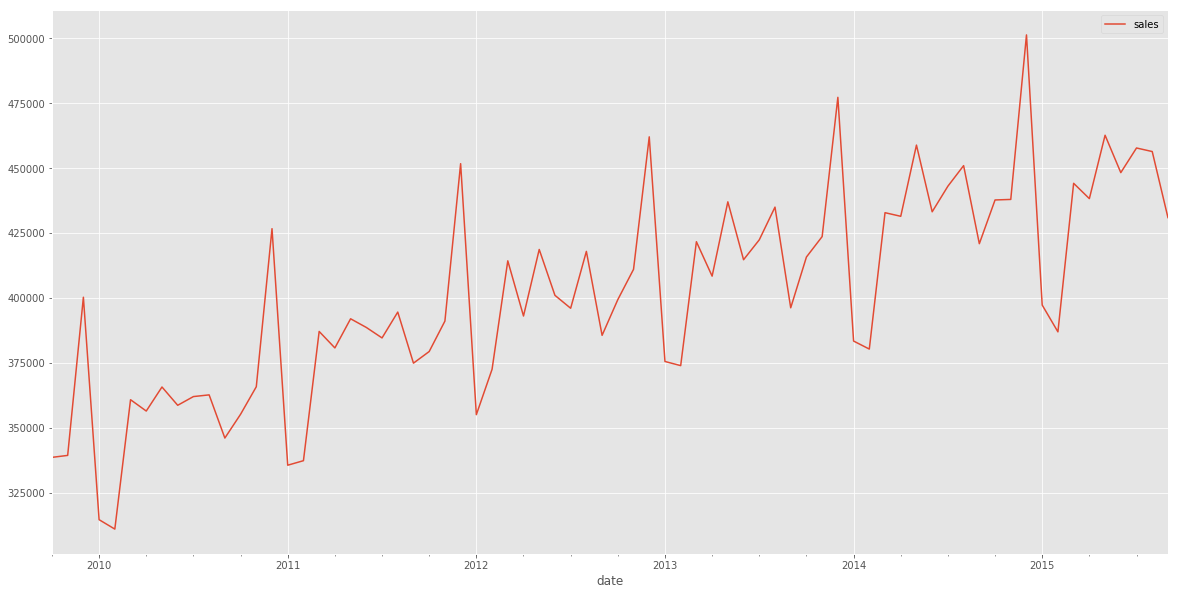

In [4]:
sales_data.plot()

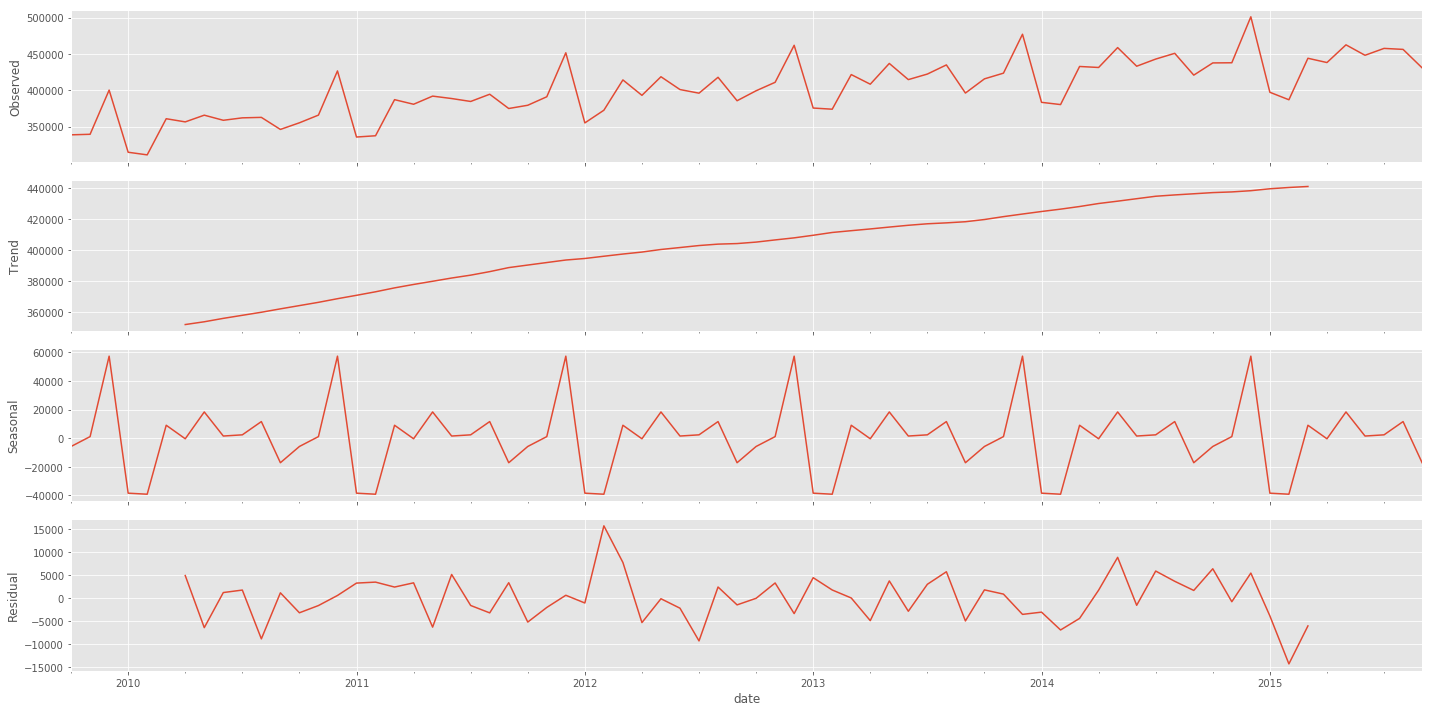

In [5]:
decomposed = seasonal_decompose(sales_data['sales'], model='additive')
x =decomposed.plot() #See note below about this

In [6]:
sales_data['stationary']=sales_data['sales'].diff()


In [7]:
sales_data.head()

sales  stationary
date                          
2009-10-01  338630         NaN
2009-11-01  339386       756.0
2009-12-01  400264     60878.0
2010-01-01  314640    -85624.0
2010-02-01  311022     -3618.0

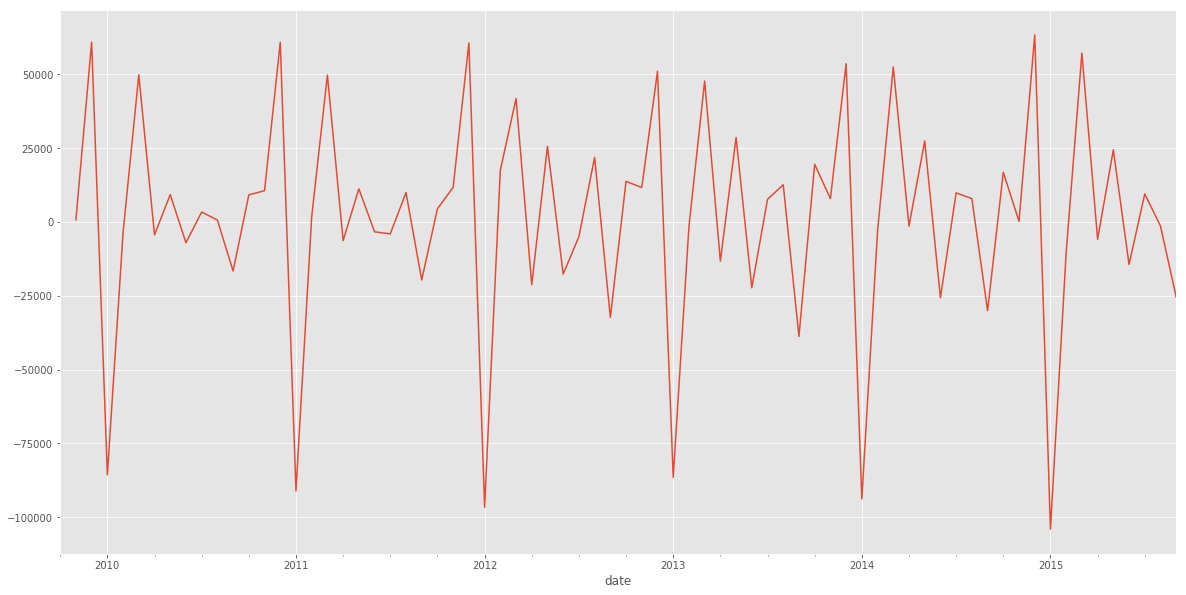

In [8]:
sales_data['stationary'].plot()

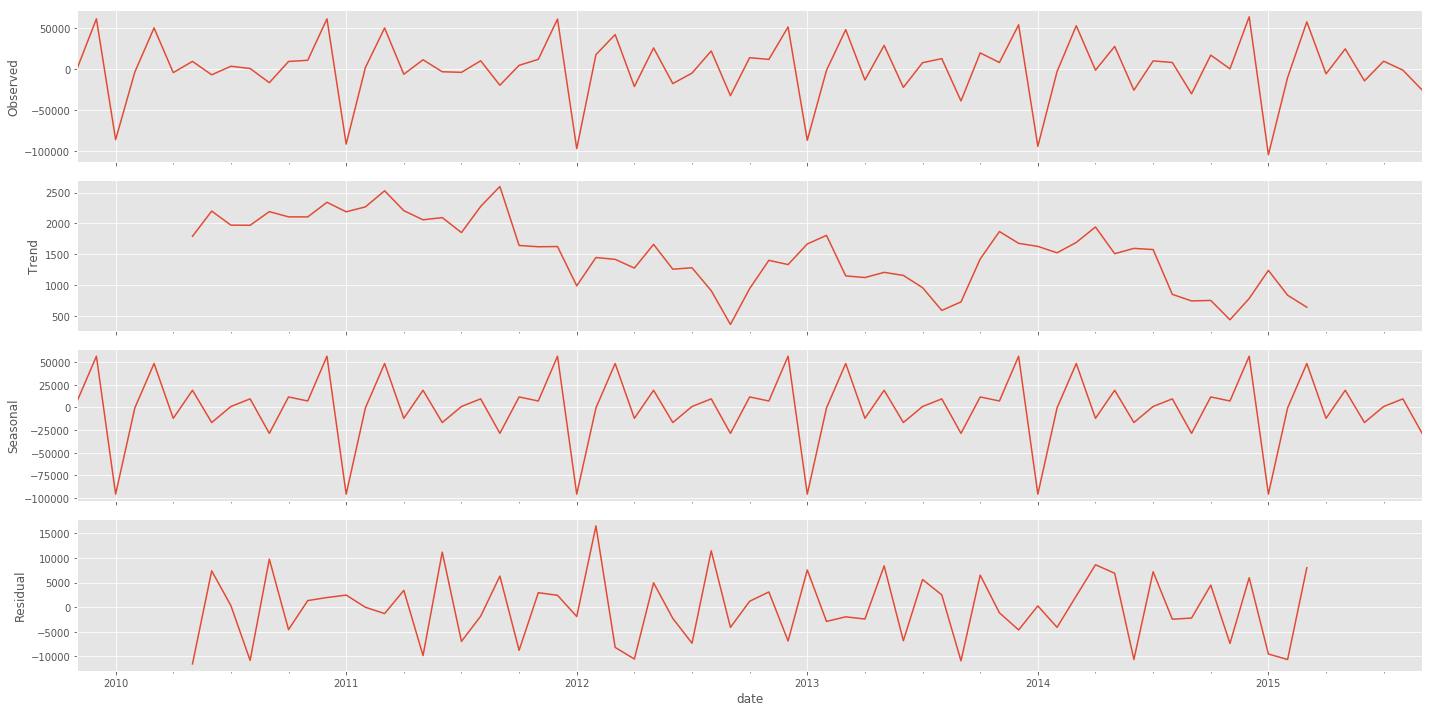

In [9]:
decomposed = seasonal_decompose(sales_data['stationary'].dropna(), model='additive')
x =decomposed.plot() #See note below about this

/vagrant/pythondata/env/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 'pandas.tools.plotting.lag_plot' is deprecated, import 'pandas.plotting.lag_plot' instead.
  """Entry point for launching an IPython kernel.


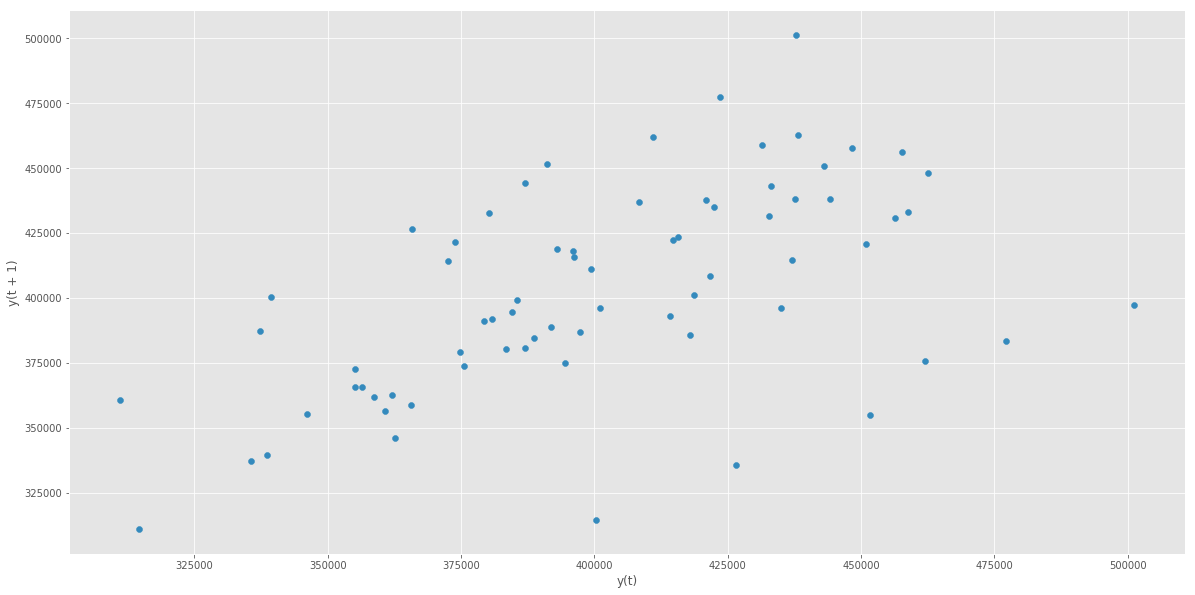

In [10]:
pd.tools.plotting.lag_plot(sales_data['sales'])

/vagrant/pythondata/env/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  


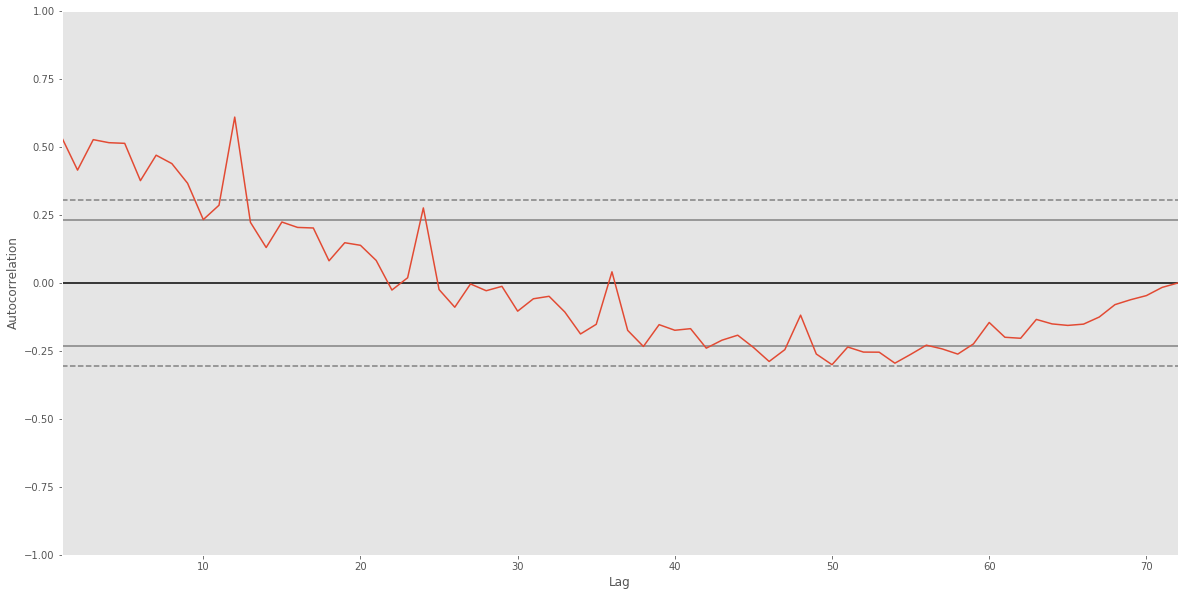

In [11]:

pd.tools.plotting.autocorrelation_plot(sales_data['sales'])

In [12]:
sales_data['sales'].corr(sales_data['sales'].shift(12))

0.97909859758957896

In [13]:
#create train/test datasets
X = sales_data['stationary'].dropna()

train_data = X[1:len(X)-12]
test_data = X[X[len(X)-12:]]


In [14]:
#train the autoregression model
model = AR(train_data)
model_fitted = model.fit()


/vagrant/pythondata/env/local/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [15]:
print('The lag value chose is: %s' % model_fitted.k_ar)


The lag value chose is: 10


In [16]:
print('The coefficients of the model are:\n %s' % model_fitted.params)

The coefficients of the model are:
 const             7720.952626
L1.stationary       -1.297636
L2.stationary       -1.574980
L3.stationary       -1.403045
L4.stationary       -1.123204
L5.stationary       -0.472200
L6.stationary       -0.014586
L7.stationary        0.564099
L8.stationary        0.792080
L9.stationary        0.843242
L10.stationary       0.395546
dtype: float64


In [17]:
# make predictions 
predictions = model_fitted.predict(
    start=len(train_data), 
    end=len(train_data) + len(test_data)-1, 
    dynamic=False)

# create a comparison dataframe
compare_df = pd.concat(
    [sales_data['stationary'].tail(12),
    predictions], axis=1).rename(
    columns={'stationary': 'actual', 0:'predicted'})

In [18]:
compare_df

actual     predicted
date                              
2014-10-01   16831.0   5601.811846
2014-11-01     208.0  38414.120561
2014-12-01   63322.0  35441.708285
2015-01-01 -103980.0 -49947.389001
2015-02-01  -10317.0 -21617.841678
2015-03-01   57175.0  20818.987209
2015-04-01   -5893.0  14274.367772
2015-05-01   24398.0  15474.495929
2015-06-01  -14386.0 -12799.912704
2015-07-01    9481.0  10743.906740
2015-08-01   -1370.0   1184.598793
2015-09-01  -25423.0 -23880.339021

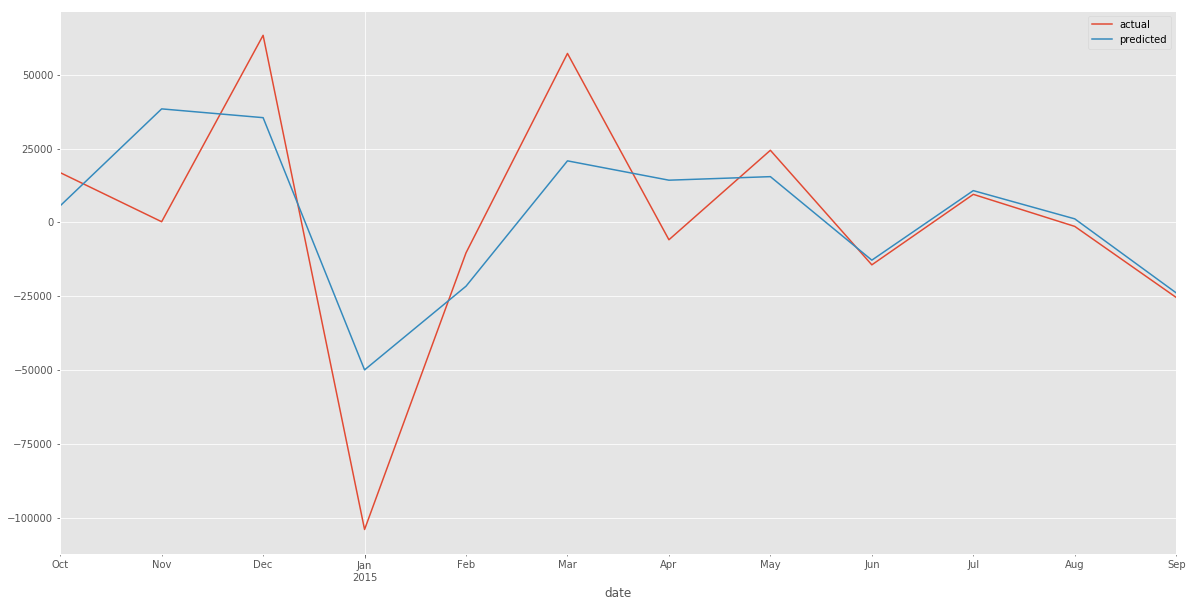

In [19]:
compare_df.plot()

In [20]:
r2 = r2_score(sales_data['stationary'].tail(12), predictions)

In [21]:
r2

0.63927217684780879